# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from suite2p import default_ops, version
from IPython.utils import io

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from filters import KalmanDenoiser, NoFilter
from interpolators import NoInterpolator, StackInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Specify input data directory

In [3]:
# Data directory
dataroot = get_data_root() # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory:\n{datadir}')

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

 01/11/2021 12:38:33: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753']


### Merge TIFs into stack

In [5]:
raw_stack_fpaths = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        raw_stack_fpaths.append(stack_tifs(tif_folder, overwrite=False))

 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 01/11/2021 12:38:33: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize a randomly chosen stack

 01/11/2021 12:38:34: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 01/11/2021 12:38:35: plotting 1 fluorescence trace(s)...
 01/11/2021 12:38:35: adding 16 delimiters
 01/11/2021 12:38:35: initializing stack viewer
 01/11/2021 12:38:35: stack size: (1600, 256, 256)
 01/11/2021 12:38:35: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 3140.17it/s]

 01/11/2021 12:38:35: intensity range: 32 - 1906
 01/11/2021 12:38:35: rendering stack view...


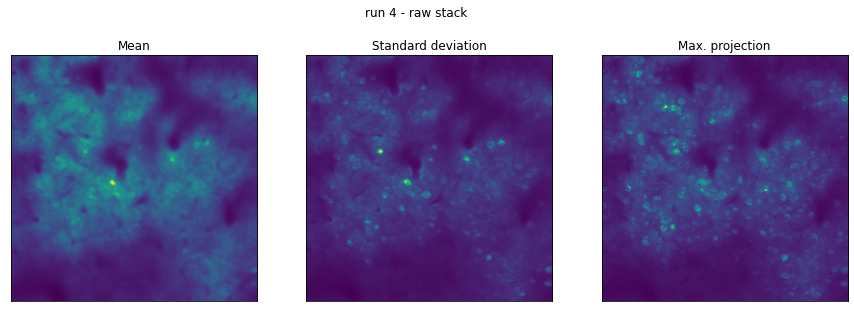

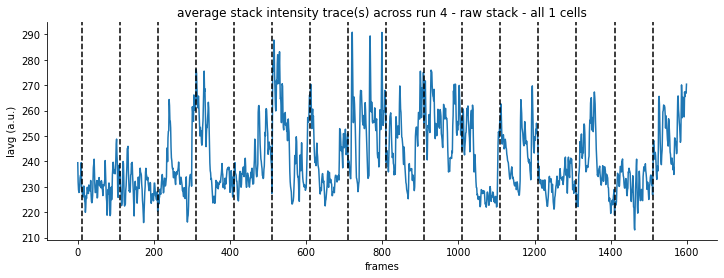

In [6]:
ifile = 4
raw_stack = loadtif(raw_stack_fpaths[ifile])

figs[f'raw_stack_run{ifile}'] = plot_stack_summary(
    raw_stack, title=f'run {ifile} - raw stack')

figs[f'stack_timecourse_run{ifile}'] = plot_raw_traces(
    np.mean(raw_stack, axis=(-2, -1)),
    title=f'run {ifile} - raw stack',
    ylabel=STACK_AVG_INT_LABEL,
    delimiters=I_STIM_FRAMES_RUN)

view_stack({
    'raw': raw_stack_fpaths[ifile]}, title=f'run {ifile}', ilabels=I_STIM_FRAMES_RUN)

We notice a significant amount of Speckle noise in the acquired images, especially on the frames corresponding to stimulation episodes.

## Interpolation of stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we replace them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [7]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Interpolate every TIF stack and save outputs in specific directory 
input_root = 'stacked'
interpolated_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, I_STIM_FRAMES_RUN, overwrite=False)

 01/11/2021 12:38:36: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 01/11/2021 12:38:36: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 01/11/2021 12:38:36: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 01/11/2021 12:38:36: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 01/11/2021 12:38:36: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3

### View interpolation output for a particular stack

 01/11/2021 12:38:36: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 01/11/2021 12:38:37: plotting 2 fluorescence trace(s)...
 01/11/2021 12:38:37: adding 16 delimiters
 01/11/2021 12:38:37: initializing stack viewer
 01/11/2021 12:38:37: stack size: (1600, 256, 256)
 01/11/2021 12:38:37: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5575.75it/s]

 01/11/2021 12:38:38: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5760.83it/s]

 01/11/2021 12:38:38: intensity range: 32 - 1906
 01/11/2021 12:38:38: rendering stack view...


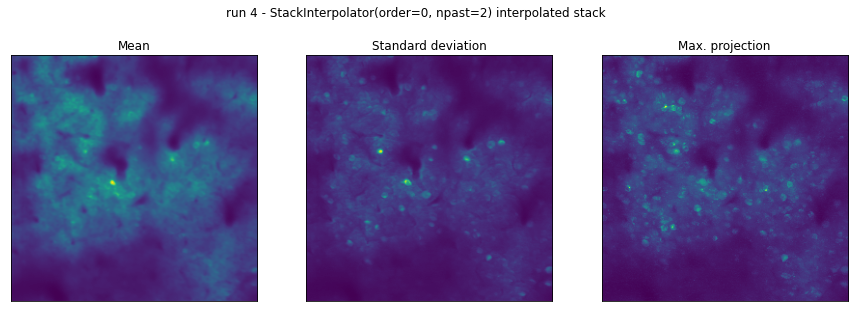

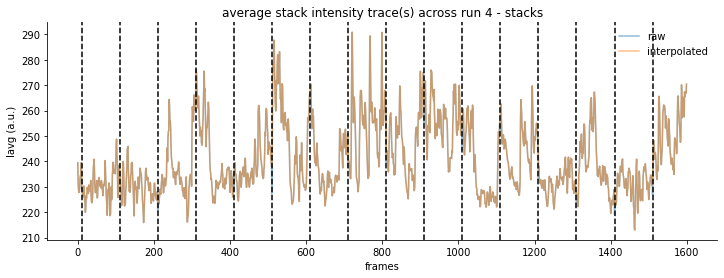

In [8]:
interpolated_stack = loadtif(interpolated_stack_fpaths[ifile])

figs[f'interp_stack_run{ifile}'] = plot_stack_summary(
    interpolated_stack, title=f'run {ifile} - {si} interpolated stack')

figs[f'stack_timecourse_run{ifile}'] = plot_raw_traces(
    np.array([
        np.mean(raw_stack, axis=(-2, -1)),
        np.mean(interpolated_stack, axis=(-2, -1))
    ]),
    labels=['raw', 'interpolated'],
    title=f'run {ifile} - stacks',
    alpha=0.5,
    ylabel=STACK_AVG_INT_LABEL,
    delimiters=I_STIM_FRAMES_RUN)

view_stack({
    'raw': raw_stack_fpaths[ifile],
    si: interpolated_stack_fpaths[ifile]},
    title=f'run {ifile}', ilabels=I_STIM_FRAMES_RUN, norm=True)

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [9]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'interpolated'
filtered_stack_fpaths = process_and_save(kd, interpolated_stack_fpaths, input_root, overwrite=False)

 01/11/2021 12:38:38: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 01/11/2021 12:38:38: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 01/11/2021 12:38:38: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 01/11/2021 12:38:38: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 01/11/2021 12:38:38: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order

### View filtering output for a particular stack

 01/11/2021 12:38:38: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 01/11/2021 12:38:40: plotting 3 fluorescence trace(s)...
 01/11/2021 12:38:40: adding 16 delimiters
 01/11/2021 12:38:40: initializing stack viewer
 01/11/2021 12:38:40: stack size: (1600, 256, 256)
 01/11/2021 12:38:40: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5417.65it/s]

 01/11/2021 12:38:40: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5776.38it/s]

 01/11/2021 12:38:40: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5655.19it/s]

 01/11/2021 12:38:41: intensity range: 63 - 1414
 01/11/2021 12:38:41: rendering stack view...


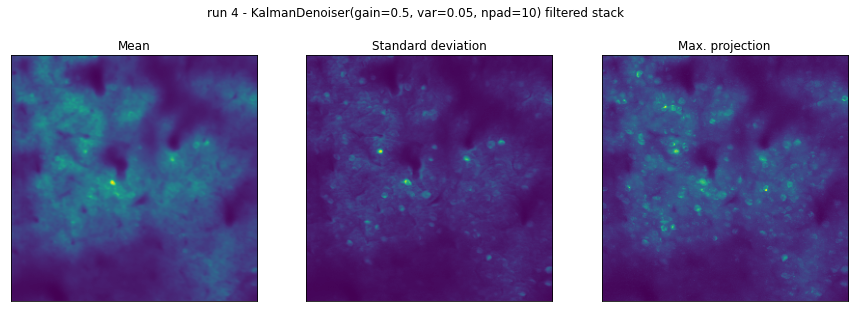

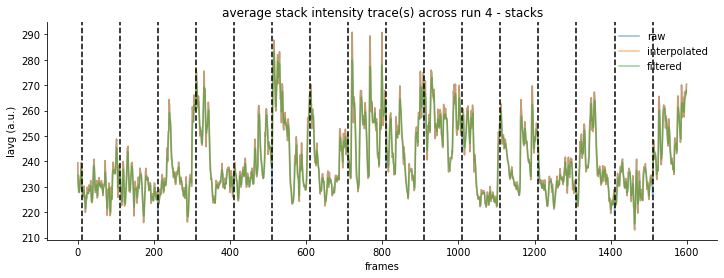

In [10]:
filtered_stack = loadtif(filtered_stack_fpaths[ifile])

figs[f'filtered_stack_run{ifile}'] = plot_stack_summary(
    filtered_stack, title=f'run {ifile} - {kd} filtered stack')

figs[f'stack_timecourse_run{ifile}'] = plot_raw_traces(
    np.array([
        np.mean(raw_stack, axis=(-2, -1)),
        np.mean(interpolated_stack, axis=(-2, -1)),
        np.mean(filtered_stack, axis=(-2, -1))
    ]),
    labels=['raw', 'interpolated', 'filtered'],
    title=f'run {ifile} - stacks',
    alpha=0.5,
    ylabel=STACK_AVG_INT_LABEL,
    delimiters=I_STIM_FRAMES_RUN)

view_stack({
    'raw': raw_stack_fpaths[ifile],
    si: interpolated_stack_fpaths[ifile],
    kd: filtered_stack_fpaths[ifile]},
    ilabels=I_STIM_FRAMES_RUN, norm=True)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [11]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=NTRIALS_PER_RUN)
fps = get_singleton(input_info_table, FPS_LABEL)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

 01/11/2021 12:38:41: parsed frame rate = 3.56 fps
 01/11/2021 12:38:41: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1


### Set suite2p pipeline parameters

In [12]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 01/11/2021 12:38:41: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [13]:
run_suite2p(ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

 01/11/2021 12:38:41: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0"
 01/11/2021 12:38:41: run options match 100% -> ignoring


### Load suite2p ouput data

In [43]:
s2p_output_fpath = os.path.join(s2p_input_dirs[0], 'suite2p', 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True)
s2p_ops = s2p_data.pop('ops')
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=NTRIALS_PER_RUN)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
nframes_per_trial = get_singleton(output_info_table, NPERTRIAL_LABEL)
nruns = len(s2p_ops['filelist'])
nframes_per_run = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run) == 1,  'inconsistent number of frames for each run'
nframes_per_run = nframes_per_run[0]
ntrials_per_run = nframes_per_run // nframes_per_trial
logger.info('output info table corresponding to suite2p processing order:')
output_info_table

 01/11/2021 12:49:05: extracted data contains 516 ROIs
 01/11/2021 12:49:05: output info table corresponding to suite2p processing order:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  \
run                                                                     
0    line3           100           0.2  3.56     0.00    50.0     757   
1    line3           100           0.2  3.56     0.10    50.0     755   
2    line3           100           0.2  3.56     0.20    50.0     754   
3    line3           100           0.2  3.56     0.40    50.0     753   
4    line3           100           0.2  3.56     0.05    50.0     756   
5    line3           100           0.2  3.56     0.60    50.0     752   
6    line3           100           0.2  3.56     0.80     5.0     748   
7    line3           100           0.2  3.56     0.80    10.0     747   
8    line3           100           0.2  3.56     0.80    20.0     746   
9    line3           100           0.2  3.56     0.80    30.0     745   
10   line3           100           0.2  3.56     0.80    40.0     744   
11   line3           100           0.2  3.56     0.80    50.0     743   
12   line3           100           0.2  3.56     0.80    60.0     749   
13   line3           100           0.2  3.56     0.80    70.0     750   
14   line3           100           0.2  3.56     0.80    80.0     751   

                                                  code  ntrials  
run                                                              
0    line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757       16  
1    line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755       16  
2    line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754       16  
3    line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753       16  
4    line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC...       16  
5    line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752       16  
6    line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748       16  
7    line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747       16  
8    line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746       16  
9    line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745       16  
10   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744       16  
11   line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743       16  
12   line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749       16  
13   line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750       16  
14   line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751       16

### Plot suite2p summary images

 01/11/2021 12:49:08: plotting suite2p registered images...


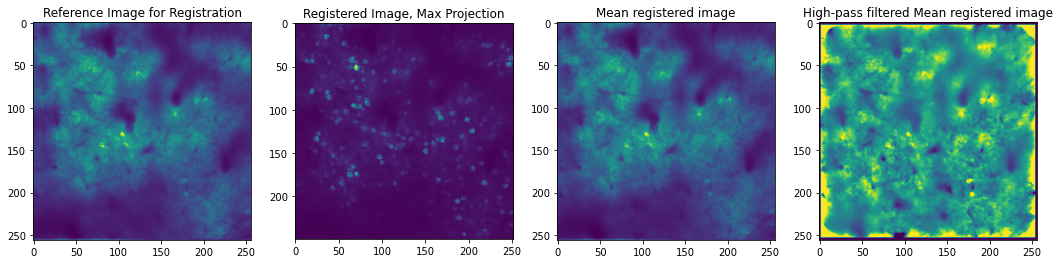

In [44]:
figs['registered_images'] = plot_suite2p_registration_images(s2p_ops)

### Plot suite2p registration offsets

 01/11/2021 12:49:09: plotting suite2p registration offsets...


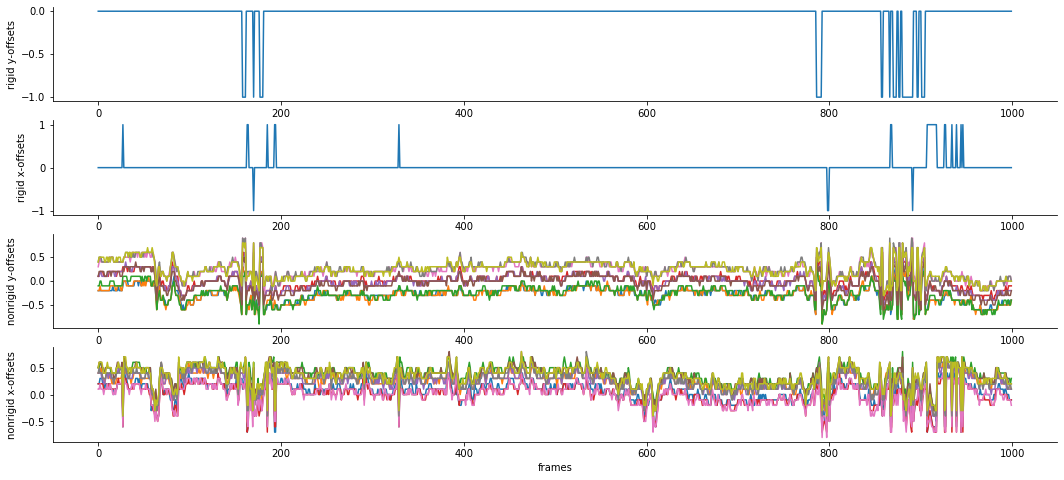

In [45]:
figs['registered_offsets'] = plot_suite2p_registration_offsets(s2p_ops)

### Visualize registered stack (for the same run as before)

In [46]:
istimframes_stacked = np.tile(I_STIM_FRAMES_RUN, (nruns, 1))
for i in range(nruns):
    istimframes_stacked[i] += i * REF_NFRAMES
istimframes_stacked = istimframes_stacked.flatten()
ifile_eq = output_to_input_mapping[ifile]
runbounds = [REF_NFRAMES * ifile_eq, REF_NFRAMES * (ifile_eq + 1) - 1]
view_stack(
    s2p_ops, title=f'registered stack (run {ifile} -> output {ifile_eq})',
    bounds=runbounds, ilabels=istimframes_stacked)

 01/11/2021 12:49:10: initializing stack viewer
 01/11/2021 12:49:10: stack size: (24000, 256, 256)
 01/11/2021 12:49:10: frame frange: [8000, 9599]
 01/11/2021 12:49:10: computing stack intensity range across 8000 - 9599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5834.47it/s]

 01/11/2021 12:49:10: intensity range: 50 - 393
 01/11/2021 12:49:10: rendering stack view...


### Compare average frame intensity for specific run

That is a good opportunity to check that our mapping of input stacks to suite2p output stacks is correct.

 01/11/2021 12:49:13: initializing stack viewer
 01/11/2021 12:49:13: stack size: (1600, 256, 256)
 01/11/2021 12:49:13: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 4445.92it/s]

 01/11/2021 12:49:13: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 4667.57it/s]

 01/11/2021 12:49:14: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5025.70it/s]

 01/11/2021 12:49:14: intensity range: 63 - 1414



100%|██████████| 1600/1600 [00:00<00:00, 6560.49it/s]

 01/11/2021 12:49:15: initializing stack viewer
 01/11/2021 12:49:15: stack size: (24000, 256, 256)
 01/11/2021 12:49:15: frame frange: [8000, 9599]
 01/11/2021 12:49:15: computing stack intensity range across 8000 - 9599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 6065.33it/s]

 01/11/2021 12:49:15: intensity range: 50 - 393



100%|██████████| 1600/1600 [00:01<00:00, 1246.34it/s]


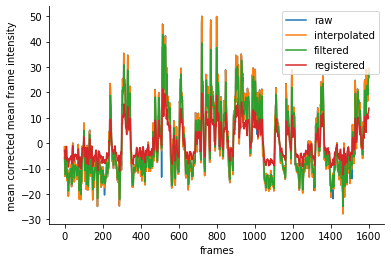

In [47]:
fig = plot_mean_evolution({
    'raw': raw_stack_fpaths[ifile],
    'interpolated': interpolated_stack_fpaths[ifile],
    'filtered': filtered_stack_fpaths[ifile]})
figs[f'avg_frame_intensity_run{ifile}'] = plot_mean_evolution(
    s2p_ops, title='registered', ilabels=istimframes_stacked, bounds=runbounds, ax=fig.axes[0])

### Inspect suite2p ROIs

 01/11/2021 12:50:23: plotting suite2p identified ROIs...


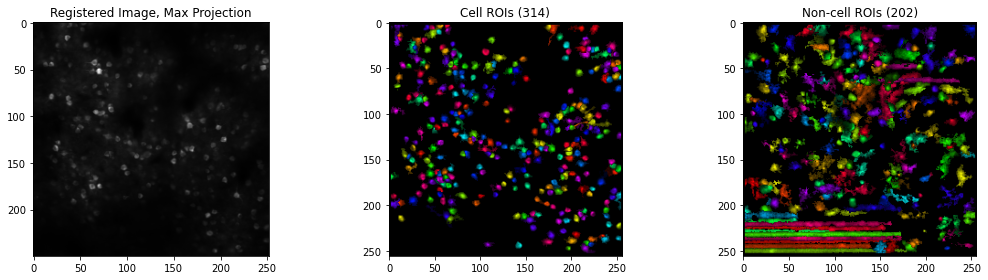

In [49]:
figs['identified_ROIs'] = plot_suite2p_ROIs(s2p_data, s2p_ops)

## Post-processing

### Filter out non-cell ROIs

In [50]:
update_suite2p_data_validity(s2p_data, s2p_data['iscell'][:, 0])

 01/11/2021 12:50:28: filtering suite2p data...
 01/11/2021 12:50:28: filtered data contains 314 valid ROIs


### Discard outliers based on morphological properties

 01/11/2021 12:50:48: filtering suite2p data...
 01/11/2021 12:50:48: filtered data contains 312 valid ROIs
 01/11/2021 12:50:48: plotting suite2p identified ROIs...
 01/11/2021 12:50:49: identified 2 outlier(s):


compact  solidity   npix  npix_soma  radius  aspect_ratio   skew
ROI                                                                  
159    False     False   True      False   False         False  False
172     True     False  False      False   False         False  False

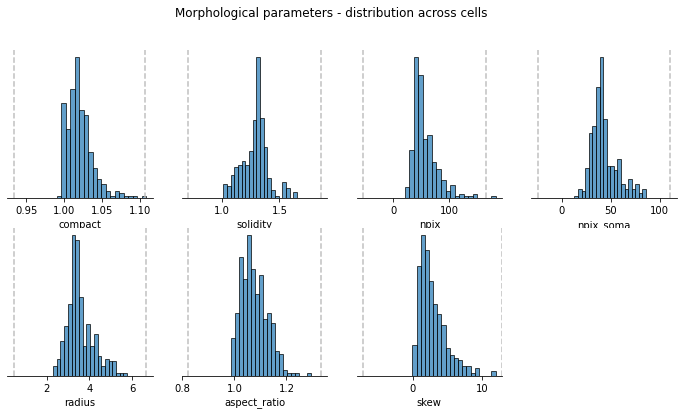

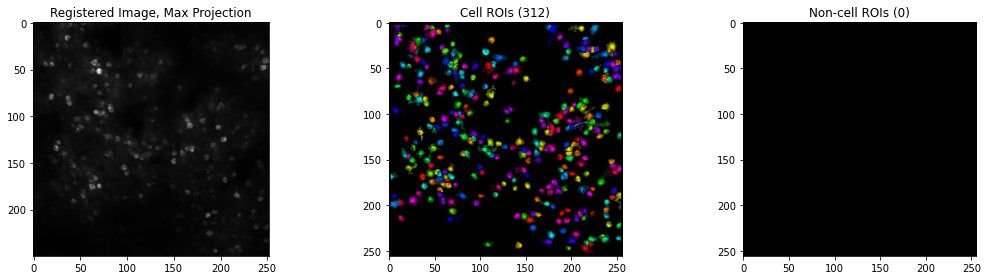

In [51]:
# Plot distributions and identify outliers
pkeys = [
    'compact',
    'solidity',
    'npix',
    'npix_soma',
    'radius',
    'aspect_ratio',
    'skew',
]
figs['morpho_params_cells'], df_outliers = plot_parameter_distributions(
    s2p_data, pkeys, zthr=5)

# Update suite2p validity index based on newly identified outliers
is_valid = np.ones(len(s2p_data[ROI_KEY])).astype(bool)
is_valid[df_outliers.index.values] = False
update_suite2p_data_validity(s2p_data, is_valid)

# Visualize the new distribution of cells in the field
figs['identified_ROIs'] = plot_suite2p_ROIs(get_filtered_suite2p_data(s2p_data), s2p_ops)

# Log identified outliers
logger.info(f'identified {len(df_outliers)} outlier(s):')
df_outliers

### Compute fluorescence data

We also plot the full fluorescence dataset to verify the suite2p output integrity 

 01/11/2021 12:51:28: extracting fluorescence data...
 01/11/2021 12:51:28: subtracting neuropil background...
 01/11/2021 12:51:28: plotting 312 fluorescence trace(s)...
 01/11/2021 12:51:29: adding 16 delimiters


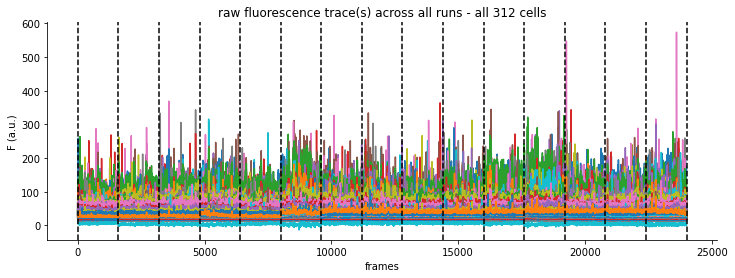

In [52]:
# Get cell-only suite2p data 
logger.info('extracting fluorescence data...')
valid_s2p_data = get_filtered_suite2p_data(s2p_data)

# Subtract neuropil background fluorescence each ROI of interest
logger.info('subtracting neuropil background...')
F = valid_s2p_data['F'] - NEUROPIL_FACTOR * valid_s2p_data['Fneu']

# Plot longitudinal fluorescence traces for all cell ROIs 
run_delimiters = np.arange(nruns + 1) * nframes_per_run
figs['raw_F_traces'] = plot_raw_traces(F, 'all runs', delimiters=run_delimiters)

### Split the data into separate runs

 01/11/2021 12:52:04: splitting fluorescence array into 15 separate runs...
 01/11/2021 12:52:04: plotting 312 fluorescence trace(s)...
 01/11/2021 12:52:04: adding 17 delimiters
 01/11/2021 12:52:04: plotting 312 fluorescence trace(s)...
 01/11/2021 12:52:05: adding 17 delimiters
 01/11/2021 12:52:05: plotting 312 fluorescence trace(s)...
 01/11/2021 12:52:05: adding 17 delimiters


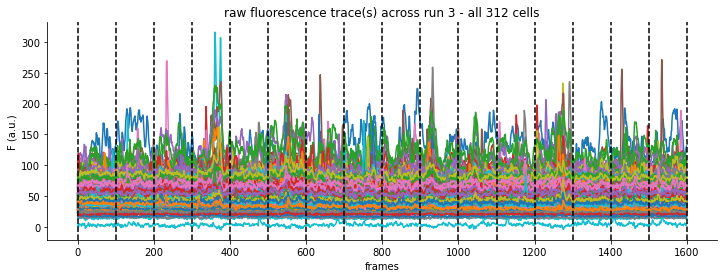

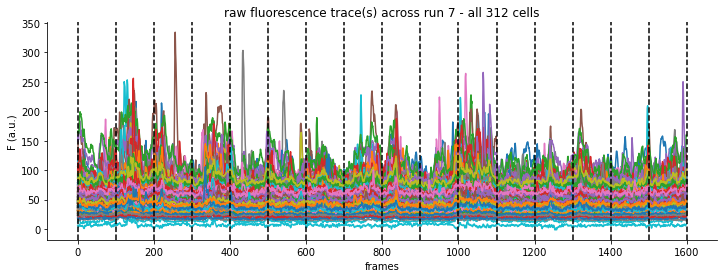

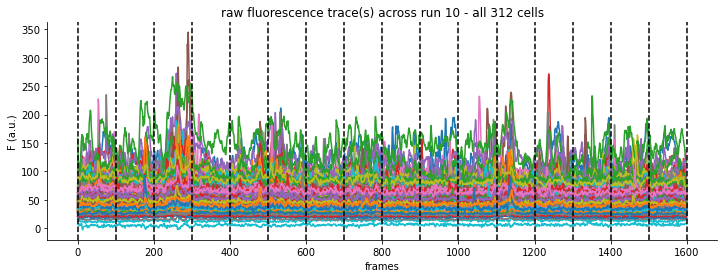

In [53]:
# Split the data into separate runs
F_per_run = separate_runs(F, nruns)

# Plot fluorescence timecourse for a few runs
trial_delimiters = np.arange(ntrials_per_run + 1) * nframes_per_trial
for irun in [3, 7, 10]:
    figs[f'raw_F_traces_run{irun}'] = plot_raw_traces(
        F_per_run[:, irun, :], f'run {irun}', delimiters=trial_delimiters)

### Compute time-varying fluorescence baseline

 01/11/2021 13:01:18: computing fluorescence baseline as 8th percentile of 5.0s (19 frames) rolling window
 01/11/2021 13:01:23: plotting 2 fluorescence trace(s)...
 01/11/2021 13:01:23: adding 17 delimiters
 01/11/2021 13:01:23: plotting 2 fluorescence trace(s)...
 01/11/2021 13:01:23: adding 17 delimiters
 01/11/2021 13:01:23: plotting 2 fluorescence trace(s)...
 01/11/2021 13:01:23: adding 17 delimiters


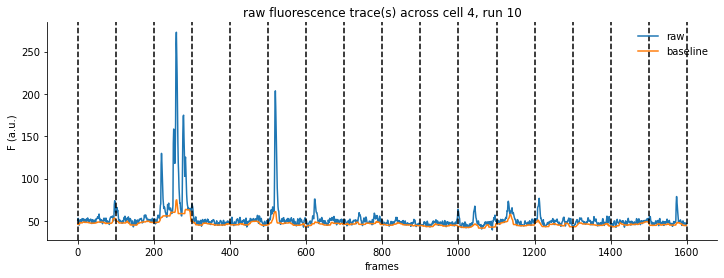

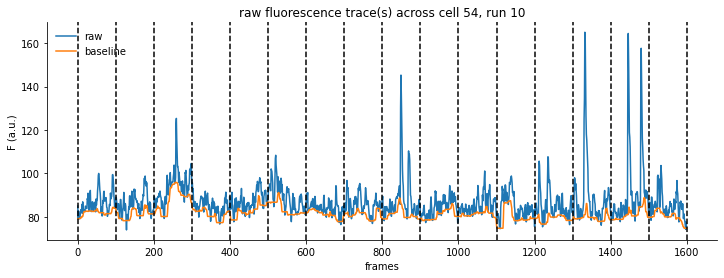

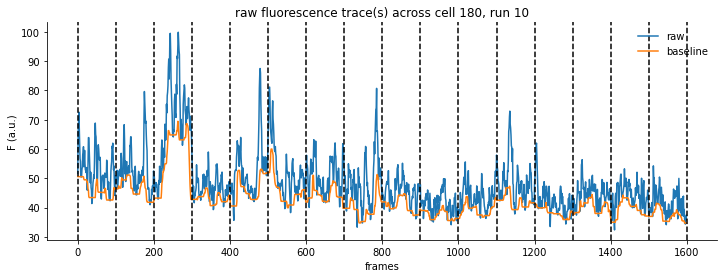

In [62]:
# Apply sliding window to compute baseline fluorescence for each cell and run
wlen = 5.
quantile = .08
F0_per_run = get_fluorescence_baseline(F_per_run, fps, wlen=wlen, quantile=quantile)

# Plot original and baseline fluorescence for a few runs
for icell in [4, 54, 180]:
    fig = plot_raw_traces(
        np.array([F_per_run[icell, irun, :], F0_per_run[icell, irun, :]]),
        f'cell {icell}, run {irun}', delimiters=trial_delimiters, labels=['raw', 'baseline'])

### Split the fluorescence data into separate trials 

 01/11/2021 13:02:31: splitting fluorescence array into 16 separate trials...
 01/11/2021 13:02:31: splitting fluorescence array into 16 separate trials...
 01/11/2021 13:02:31: plotting 312 fluorescence trace(s)...
 01/11/2021 13:02:31: plotting 312 fluorescence trace(s)...
 01/11/2021 13:02:31: plotting 312 fluorescence trace(s)...


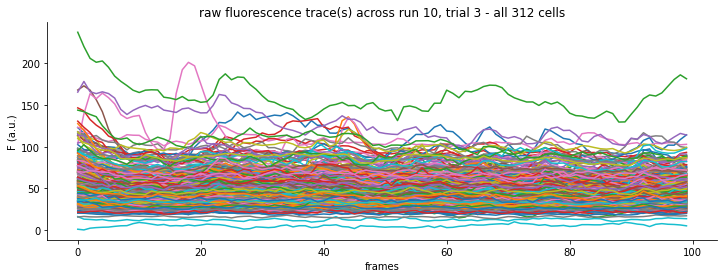

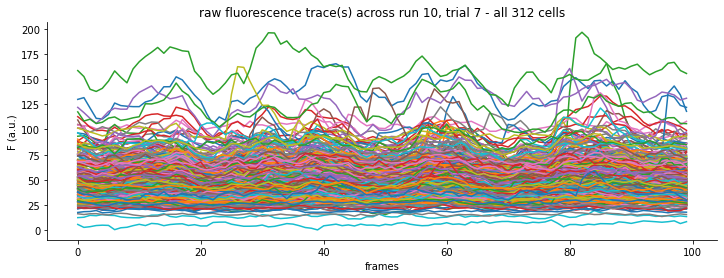

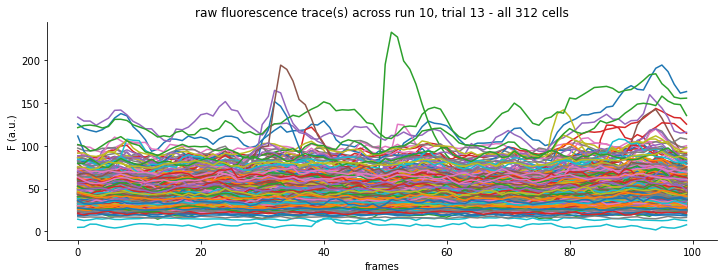

In [64]:
# Split fluorescence data into separate trials
F_per_trial = separate_trials(F_per_run, ntrials_per_run)
F0_per_trial = separate_trials(F0_per_run, ntrials_per_run)

# Plot fluorescence timecourse of specific run for a few trials
for itrial in [3, 7, 13]:
    figs[f'corrected_F_traces_run{irun}_trial{itrial}'] = plot_raw_traces(
        F_per_trial[:, irun, itrial],
        f'run {irun}, trial {itrial}')

### Apply trial-specific baseline correction to fluorescence signal

In [68]:
F_per_trial_corrected = F_per_trial - F0_per_trial + np.expand_dims(F0_per_trial.mean(axis=-1), -1)

### Compute relative fluorescence change for each trial

 01/11/2021 13:07:27: computing relative fluorescence change...
 01/11/2021 13:07:27: plotting 312 fluorescence trace(s)...
 01/11/2021 13:07:27: plotting 312 fluorescence trace(s)...
 01/11/2021 13:07:27: plotting 312 fluorescence trace(s)...


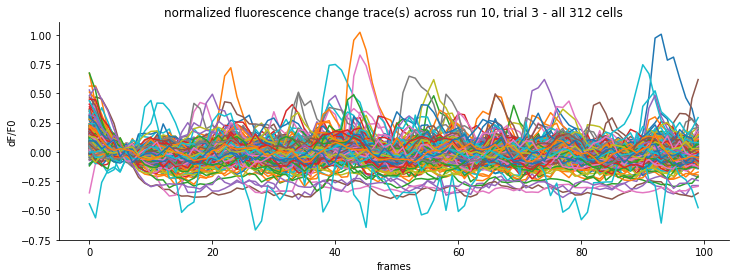

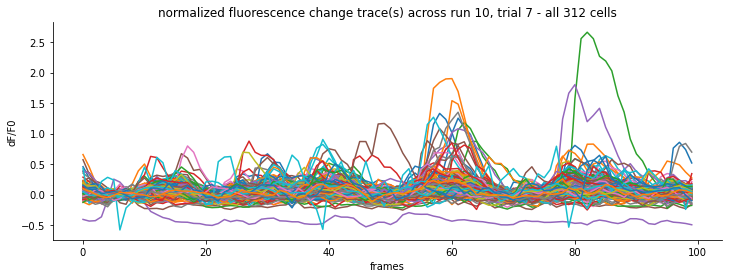

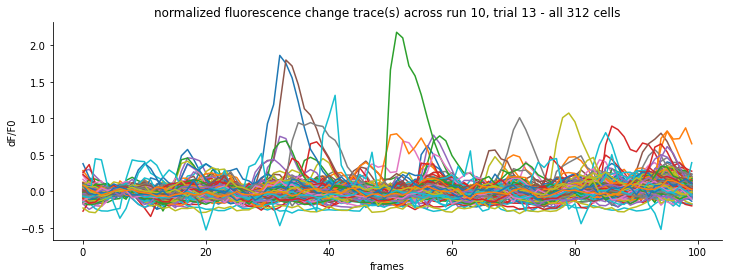

In [70]:
dFF_per_trial = get_relative_fluorescence_change(F_per_trial_corrected, I_BASELINE)
# dFF_per_trial_corrected = get_relative_fluorescence_change(F_per_trial_corrected, I_BASELINE)

# Plot relative fluorescence timecourse of specific run for a few trials
for itrial in [3, 7, 13]:
    figs[f'dFF_traces_run{irun}_trial{itrial}'] = plot_raw_traces(
        dFF_per_trial[:, irun, itrial],
        f'run {irun}, trial {itrial}',
        ylabel=REL_F_CHANGE_LABEL)

### Identify and remove outlier cells based on dFF timecourse

In [71]:
# Identify outliers based on trial-averaged dFF timecourse
dFF_thr = .5
df_outliers = get_outliers_from_dFF_activity(dFF_per_trial.mean(axis=-2), thr=dFF_thr)

# Remove identified outliers from dFF matrix
is_valid = np.ones(dFF_per_trial.shape[0]).astype(bool)
is_valid[df_outliers.index.values] = False
dFF_per_trial = dFF_per_trial[is_valid.nonzero()[0], :, :]

# Update suite2p validity index based on newly identified outliers
df_outliers[ROI_KEY] = get_filtered_suite2p_data(s2p_data)[ROI_KEY][df_outliers.index.values]
df_outliers = df_outliers.set_index(ROI_KEY)
is_valid = np.ones(len(s2p_data[ROI_KEY])).astype(bool)
is_valid[df_outliers.index.values] = False
update_suite2p_data_validity(s2p_data, is_valid)

assert dFF_per_trial.shape[0] == len(get_filtered_suite2p_data(s2p_data)[ROI_KEY]), 'Inconsistency between fluorescence array and s2p data dictionary'

# Log identified outliers
logger.info(f'identified {len(df_outliers)} outlier(s):')
df_outliers

 01/11/2021 13:07:32: filtering suite2p data...
 01/11/2021 13:07:32: filtered data contains 311 valid ROIs
 01/11/2021 13:07:32: identified 1 outlier(s):


peak |dFF|  |dFF| > 0.5
ROI                         
394    4.206567         True

### <span style="color:red">TODO: Ignore 1st trial of each run???</span>

### Classify cells by response type (computing z-scores from trial-averaged data)

 01/11/2021 13:07:38: computing z-score distributions on trial-averaged data
 01/11/2021 13:07:38: restricting analysis to response interval
 01/11/2021 13:07:38: Identified response types classes:
    - negative: 13
    - neutral: 2
    - positive: 296


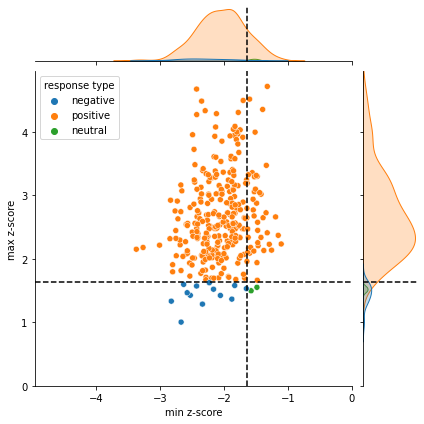

In [72]:
# Compute response type for each cell
resp_types, (zmin_dist, zmax_dist) = classify_by_response_type(dFF_per_trial, full_output=True)

# Plot associated z-scores distributions
figs['zscore_distributions'] = plot_zscore_distributions(zmin_dist, zmax_dist, resp_types)

s = "\n".join([f"    - {v}: {sum(resp_types == k)}" for k, v in LABEL_BY_TYPE.items()])
logger.info(f'Identified response types classes:\n{s}')

### Add everything to global experiment dataframe

<span style="color:red">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [73]:
# Add cells and trial info to table
data = add_cells_to_table(output_info_table, get_filtered_suite2p_data(s2p_data)[ROI_KEY])
del data['code']
data = add_trials_to_table(data)
# Add fluorescence and time signals
# data = add_signal_to_table(data, F_LABEL, F_per_trial)
data = add_signal_to_table(data, REL_F_CHANGE_LABEL, dFF_per_trial)
data = add_time_to_table(data)
# Add response type
data[RESP_LABEL] = resp_types[data.index.get_level_values('cell')]
# Log output
logger.info('data table:')
data

 01/11/2021 13:07:50: adding 311 cells info to table...
 01/11/2021 13:07:50: adding 16 trials info to table...
 01/11/2021 13:07:50: adding 311 x 15 x 16 x 100 dF/F0 signal array to table...
 01/11/2021 13:07:56: adding time info to table...
 01/11/2021 13:07:57: data table:


line  duration (s)  P (MPa)  DC (%)  run ID  roi  \
cell run trial frame                                                      
0    0   0     0      line3           0.2      0.0    50.0     757    0   
               1      line3           0.2      0.0    50.0     757    0   
               2      line3           0.2      0.0    50.0     757    0   
               3      line3           0.2      0.0    50.0     757    0   
               4      line3           0.2      0.0    50.0     757    0   
...                     ...           ...      ...     ...     ...  ...   
310  14  15    95     line3           0.2      0.8    80.0     751  514   
               96     line3           0.2      0.8    80.0     751  514   
               97     line3           0.2      0.8    80.0     751  514   
               98     line3           0.2      0.8    80.0     751  514   
               99     line3           0.2      0.8    80.0     751  514   

                         dF/F0   time (s)  response type  
cell run trial frame                                      
0    0   0     0     -0.049182  -2.808989             -1  
               1      0.060364  -2.528090             -1  
               2       0.06435  -2.247191             -1  
               3       0.03006  -1.966292             -1  
               4     -0.070269  -1.685393             -1  
...                        ...        ...            ...  
310  14  15    95     -0.12302  23.876404              1  
               96    -0.087837  24.157303              1  
               97    -0.129185  24.438202              1  
               98    -0.163365  24.719101              1  
               99    -0.154226  25.000000              1  

[7464000 rows x 9 columns]

## Visualizing results 

### Spatial distribution of cells per response type

 01/11/2021 13:08:08: extracting responses types per cell...
 01/11/2021 13:08:10: plotting cells map color-coded by response type...


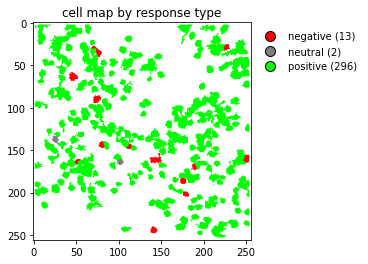

In [74]:
figs['cellmap'] = plot_cell_map(
    data, get_filtered_suite2p_data(s2p_data), title='cell map by response type')

### Cluster map of cell responses

 01/11/2021 13:08:23: extracting responses types per cell...
 01/11/2021 13:08:25: generating (roi x time) dF/F0 pivot table...
 01/11/2021 13:08:31: generating dF/F0 cluster map...


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


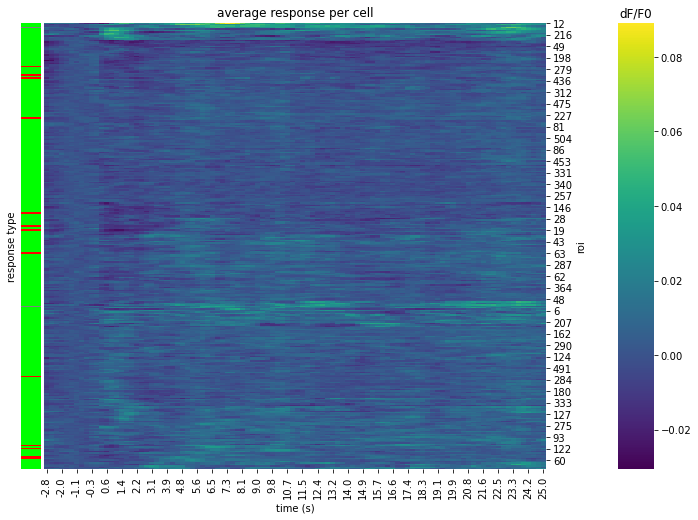

In [75]:
figs['clustermap'] = plot_experiment_heatmap(data, title='average response per cell')

## Plot dF/F0 traces

In [76]:
ybounds = [-.3, .3]

### Individual traces, mean and 95% CI for a specific cell and run

 01/11/2021 16:52:23: sub-indexing data...
 01/11/2021 16:52:23: filtering data...
 01/11/2021 16:52:23: extracting responses types per cell...
 01/11/2021 16:52:23: averaging, estimating confidence intervals and plotting...
 01/11/2021 16:52:25: plotting individual traces...


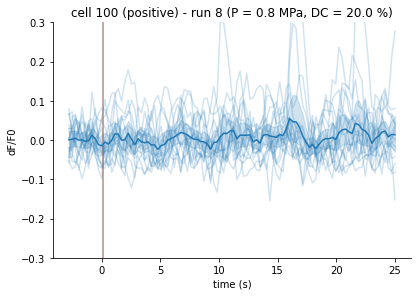

In [176]:
icell = 100
irun = 8
figs[f'response_cell{icell}_run{irun}'] = plot_responses(
    data, icell=icell, irun=irun, aggfunc='mean', alltraces=True, ybounds=ybounds)

### Individual traces, mean and 95% CI for a particular (cell, pressure, duty cycle) combination 

 01/11/2021 17:30:16: sub-indexing data...
 01/11/2021 17:30:16: filtering data...
 01/11/2021 17:30:16: extracting responses types per cell...
 01/11/2021 17:30:16: averaging, estimating confidence intervals and plotting...
 01/11/2021 17:30:17: plotting individual traces...


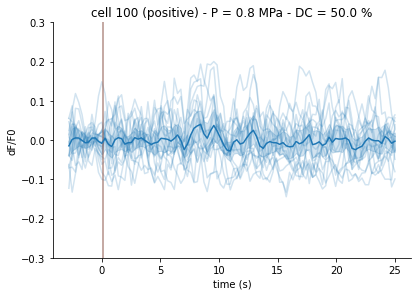

In [201]:
P = P_REF
DC = DC_REF
figs[f'response_cell{icell}_P{P}MPa_DC{DC}%'] = plot_responses(
    data, icell=icell, P=P, DC=DC, aggfunc='mean', alltraces=True, ybounds=ybounds)

### Mean trace and 95% CI, for specific (cell, duty cycle), across pressure amplitudes

 01/11/2021 17:30:22: sub-indexing data...
 01/11/2021 17:30:22: filtering data...
 01/11/2021 17:30:22: extracting responses types per cell...
 01/11/2021 17:30:22: grouping by P (MPa), averaging, estimating confidence intervals and plotting...


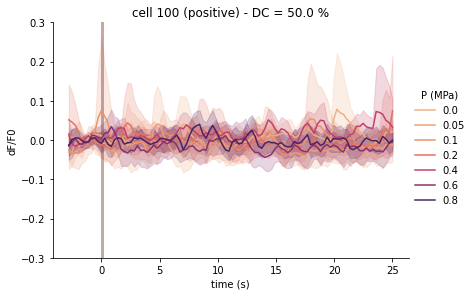

In [202]:
figs[f'response_cell{icell}_DC{DC}%_ci'] = plot_responses(
    data, icell=icell, DC=DC, hue=P_LABEL, ybounds=ybounds)

### Mean trace and 95% CI, for specific (cell, pressure), across duty cycles

 01/11/2021 17:30:32: sub-indexing data...
 01/11/2021 17:30:32: filtering data...
 01/11/2021 17:30:32: extracting responses types per cell...
 01/11/2021 17:30:32: grouping by DC (%), averaging, estimating confidence intervals and plotting...


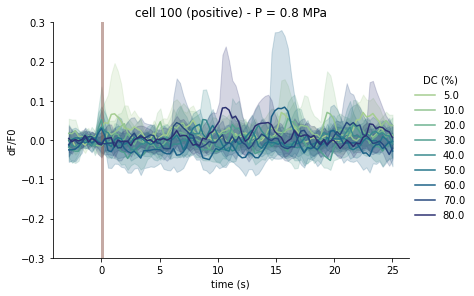

In [203]:
figs[f'response_cell{icell}_P{P}MPa_ci'] = plot_responses(
    data, icell=icell, P=P, hue=DC_LABEL, ybounds=ybounds)

### Mean trace and 95% CI for a specific duty cycle, across pressure amplitudes, per response type

 01/11/2021 17:35:18: sub-indexing data...
 01/11/2021 17:35:21: filtering data...
 01/11/2021 17:35:24: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting...


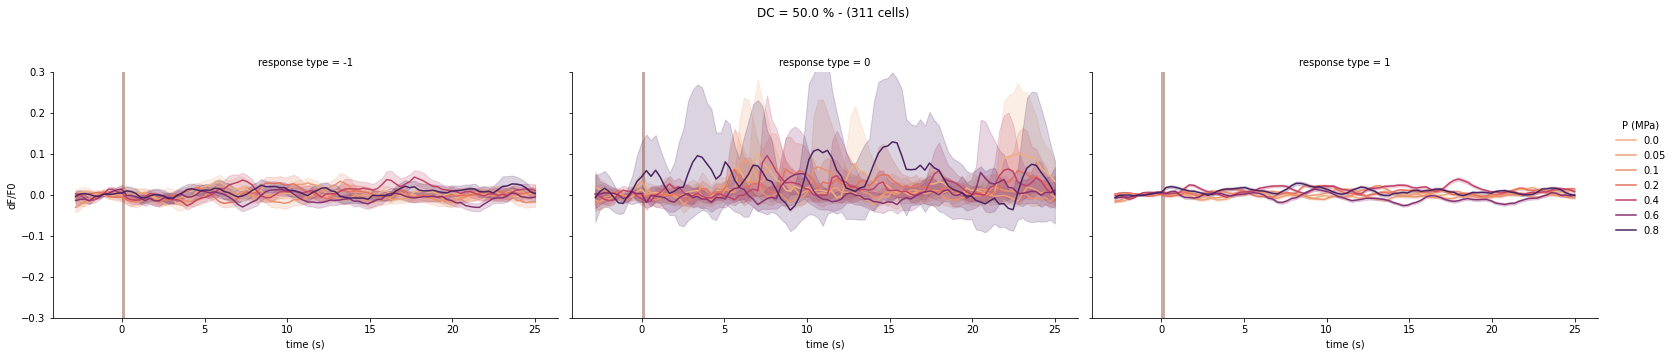

In [208]:
figs[f'responses_by_type_DC{DC}%'] = plot_responses(
    data, DC=DC_REF, hue=P_LABEL, col=RESP_LABEL, ybounds=ybounds)

### Mean trace and 95% CI for a specific pressure, across duty cycles, per response type 

 01/11/2021 17:43:30: sub-indexing data...
 01/11/2021 17:43:36: filtering data...
 01/11/2021 17:43:38: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting...


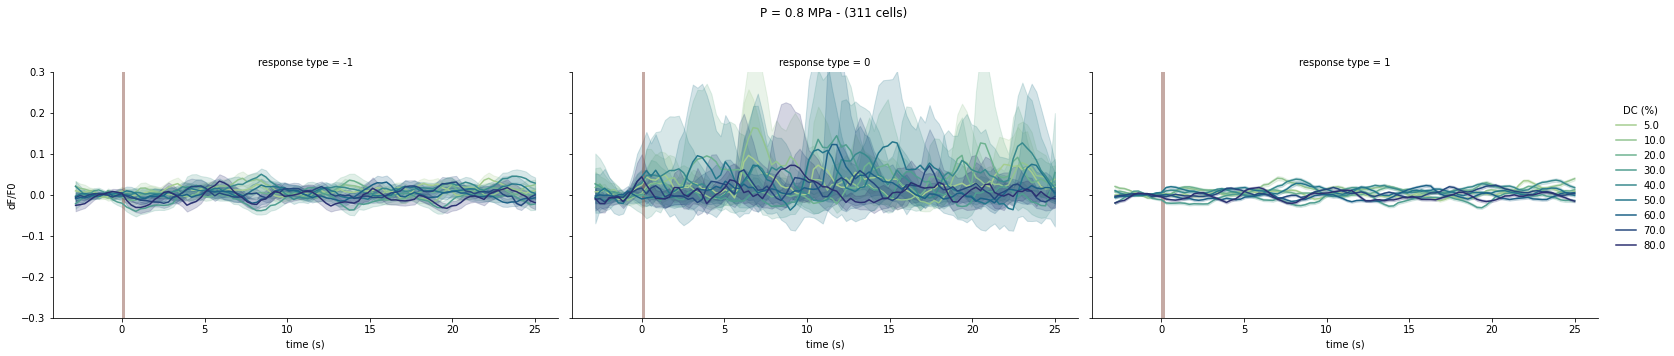

In [209]:
figs[f'responses_by_type_P{P}MPa'] = plot_responses(
    data, P=P_REF, hue=DC_LABEL, col=RESP_LABEL, ybounds=ybounds)

### Save figures

In [39]:
figsdir = os.path.join(s2p_input_dir, 'figs')
save_figs(figsdir, figs)

 01/11/2021 12:44:47: saving "raw_stack_run4.png"
 01/11/2021 12:44:48: saving "stack_timecourse_run4.png"
 01/11/2021 12:44:48: saving "interp_stack_run4.png"
 01/11/2021 12:44:48: saving "filtered_stack_run4.png"
 01/11/2021 12:44:48: saving "registered_images.png"
 01/11/2021 12:44:48: saving "registered_offsets.png"
 01/11/2021 12:44:48: saving "avg_frame_intensity_run4.png"
 01/11/2021 12:44:48: saving "identified_ROIs.png"
 01/11/2021 12:44:49: saving "morpho_params_cells.png"
 01/11/2021 12:44:49: saving "raw_F_traces.png"
 01/11/2021 12:44:52: saving "raw_F_traces_run3.png"
 01/11/2021 12:44:53: saving "raw_F_traces_run7.png"
 01/11/2021 12:44:53: saving "raw_F_traces_run10.png"
 01/11/2021 12:44:54: saving "corrected_F_traces_run10_trial3.png"
 01/11/2021 12:44:54: saving "corrected_F_traces_run10_trial7.png"
 01/11/2021 12:44:54: saving "corrected_F_traces_run10_trial13.png"
 01/11/2021 12:44:54: saving "dFF_traces_run10_trial3.png"
 01/11/2021 12:44:54: saving "dFF_traces_ru

### Save stacks as GIFs

In [40]:
#raw and fileted stacks from specific run
save_stack_to_gif(
    figsdir, {'raw': raw_stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
    ilabels=I_STIM_FRAMES_RUN)
# registered stack (slice corresponding to specific run)
save_stack_to_gif(
    figsdir, s2p_ops, title='registered',
    ilabels=istimframes_stacked, bounds=runbounds)

 01/11/2021 12:44:58: initializing stack viewer
 01/11/2021 12:44:58: stack size: (1600, 256, 256)
 01/11/2021 12:44:58: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 3769.55it/s]

 01/11/2021 12:44:58: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 4087.92it/s]

 01/11/2021 12:44:58: intensity range: 63 - 1414
 01/11/2021 12:44:58: exporting "raw.gif"...



100%|██████████| 1600/1600 [00:14<00:00, 111.56it/s]

 01/11/2021 12:45:13: exporting "filtered.gif"...



100%|██████████| 1600/1600 [00:15<00:00, 105.54it/s]

 01/11/2021 12:45:28: initializing stack viewer


 01/11/2021 12:45:28: stack size: (24000, 256, 256)
 01/11/2021 12:45:28: frame frange: [8000, 9599]
 01/11/2021 12:45:28: computing stack intensity range across 8000 - 9599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5943.47it/s]

 01/11/2021 12:45:28: intensity range: 50 - 393
 01/11/2021 12:45:28: exporting "registered.gif"...



100%|██████████| 1600/1600 [00:19<00:00, 83.97it/s]
